# Creación de modelo matemático para estimar la probabilidad de defunción dependiendo de las condiciones del paciente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn import linear_model

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## Se cargan el dataset principal y los secundarios que serviran para hacer variables categóricas

In [2]:
mainpath = "C:/Users/alana/Documents/GitHub/COVIDSTATSMX/Datos Abiertos"
mainFile = "210120COVID19MEXICO.csv"
sexoPath = "Sexo.xlsx"
sectorPath = "Sector.xlsx"
entidadPath = "Entidad.xlsx"

In [3]:
data = pd.read_csv(os.path.join(mainpath,mainFile), encoding = 'latin1')

In [4]:
sexoData = pd.read_excel(os.path.join(mainpath,sexoPath))
sectorData = pd.read_excel(os.path.join(mainpath,sectorPath))
entidadData = pd.read_excel(os.path.join(mainpath,entidadPath))

In [5]:
sectorData.head()

,SECTOR,SECTOR_V
0,1,CRUZ ROJA
1,2,DIF
2,3,ESTATAL
3,4,IMSS
4,5,IMSS-BIENESTAR


In [6]:
data.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

In [7]:
data.shape

(4244955, 40)

In [8]:
a = len(data[(data["SEXO"] == 99)
| (data["SECTOR"] == 99)
| (data["ENTIDAD_UM"] >= 97 )])

In [9]:
a

31

### Nos indica que hay 31 valores que podemos quitar para tener 5 variables categóricas menos, como son pocos comparados con el tamaño de la muestra no afecta el resultado final, se 

In [10]:
# Se filtra el dataset para eliminar casos con información No especificada (leer el diccionario de datos) y se toman solamente los casos positivos
data = data[(data["SEXO"] != 99)
& (data["SECTOR"] != 99)
& (data["ENTIDAD_UM"] < 97 )
& (data["CLASIFICACION_FINAL"] <= 3)]
# Categorias con SI-NO
data["EMBARAZO"] = np.where(data["SEXO"] == 2,2,data["EMBARAZO"])
cats = ['NEUMONIA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
      'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','EMBARAZO']
for c in cats:
    data = data[data[c] <= 3]
    data[c] = np.where(data[c] == 1 ,1,0)
data.shape

(1673125, 40)

In [11]:
data[["SEXO","EMBARAZO"]].head(10)

,SEXO,EMBARAZO
0,2,0
1,2,0
2,2,0
3,1,0
4,2,0
5,2,0
6,2,0
7,2,0
8,1,0
9,2,0


### A la fecha hay oficialmente 1,688,944 casos positivos, con los obtenidos en el filtro anterior hay una diferencia de 10660, esto se debe a que se eliminaron casos con información no especificada

In [12]:
data.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-01-20,00219f,2,12,21,2,21,21,114,1,...,1,1,1,2,97,3,99,MÃ©xico,97,97
1,2021-01-20,0a466d,1,6,30,2,29,30,131,1,...,1,1,1,2,97,3,99,MÃ©xico,97,97
2,2021-01-20,17fec5,1,9,9,2,24,9,16,1,...,2,1,1,2,97,3,99,MÃ©xico,97,97
3,2021-01-20,13adfc,1,4,30,1,15,30,131,2,...,99,1,1,2,97,3,99,MÃ©xico,97,2
4,2021-01-20,099892,1,4,8,2,8,8,37,2,...,99,1,1,2,97,3,99,MÃ©xico,97,2


In [13]:
datetime.datetime.strptime("2020-01-10","%Y-%m-%d").date()

datetime.date(2020, 1, 10)

In [14]:
print(datetime.datetime.now().date())

2021-01-22


In [15]:
data["FECHA_INGRESO"] = data["FECHA_INGRESO"].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d").date())
data["FECHA_SINTOMAS"] = data["FECHA_SINTOMAS"].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d").date())
data.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int32
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int32
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int32
EPOC                      int32
ASMA                      int32
INMUSUPR                  int32
HIPERTENSION              int32
OTRA_COM                  int32
CARDIOVASCULAR            int32
OBESIDAD                  int32
RENAL_CRONICA             int32
TABAQUISMO                int32
OTRO_CASO                 int64
TOMA_MUE

In [16]:
data[["FECHA_INGRESO","FECHA_SINTOMAS"]].head()

,FECHA_INGRESO,FECHA_SINTOMAS
0,2020-03-30,2020-03-30
1,2020-03-25,2020-03-21
2,2020-03-12,2020-03-08
3,2020-03-26,2020-03-26
4,2020-03-25,2020-03-25


In [17]:
# Se filtran para solo tomar en cuenta los casos que se ingresaron antes del 1 de enero de 2021
data = data[data["FECHA_INGRESO"] < datetime.datetime(2021,1,1).date()]
len(data)

1468711

In [18]:
data = pd.merge(data,sexoData, how = "inner", on = "SEXO")
data = pd.merge(data,sectorData, how = "inner", on = "SECTOR")
data = pd.merge(data,entidadData, how = "inner", on = "ENTIDAD_UM")

In [19]:
data["DIAS_PAS"] = data["FECHA_INGRESO"]-data["FECHA_SINTOMAS"]
data["DIAS_PAS"] = data["DIAS_PAS"].apply(lambda x:x.days)

In [20]:
data.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int32
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int32
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int32
EPOC                      int32
ASMA                      int32
INMUSUPR                  int32
HIPERTENSION              int32
OTRA_COM                  int32
CARDIOVASCULAR            int32
OBESIDAD                  int32
RENAL_CRONICA             int32
TABAQUISMO                int32
OTRO_CASO                 int64
TOMA_MUE

## Se realiza un análisis exploratorio

In [21]:
# Se agrega la columna Y (FALLECIDOS), si no ha fallecido la persona la fecha de defuncion es 9999-99-99
data["FALLECIDO"] = np.where(data["FECHA_DEF"] != "9999-99-99",1,0)

In [22]:
data["FALLECIDO"].value_counts()

0    1334852
1     133859
Name: FALLECIDO, dtype: int64

<AxesSubplot:xlabel='SECTOR_V'>

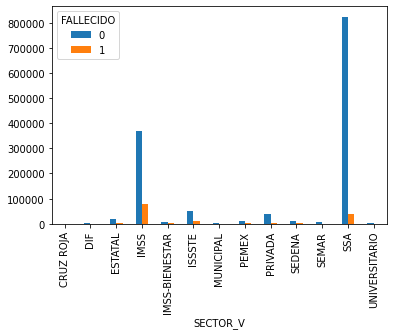

In [23]:
%matplotlib inline
pd.crosstab(data.SECTOR_V, data.FALLECIDO).plot(kind = "bar")


In [24]:
tabla = pd.crosstab(data.SECTOR_V, data.FALLECIDO)
tabla["Letalidad"] = tabla[1]/(tabla[0]+tabla[1])
tabla = tabla.sort_values(by = ["Letalidad"])
tabla

FALLECIDO,0,1,Letalidad
SECTOR_V,,,
DIF,679,0,0.000000
MUNICIPAL,1187,40,0.032600
SSA,824106,37136,0.043119
PRIVADA,38249,2133,0.052821
CRUZ ROJA,140,11,0.072848
SEMAR,5901,475,0.074498
ESTATAL,18776,2435,0.114799
IMSS-BIENESTAR,7928,1119,0.123687
UNIVERSITARIO,908,153,0.144204


<AxesSubplot:xlabel='SECTOR_V'>

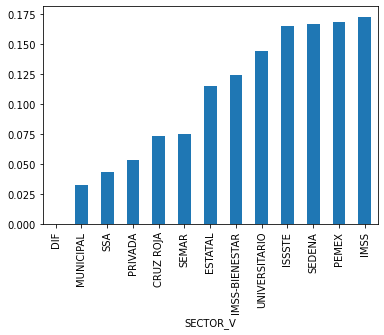

In [25]:
%matplotlib inline
tabla["Letalidad"].plot(kind = "bar")
#plt.bar(tabla.index, tabla["Letalidad"])

In [26]:
tabla = pd.crosstab(data.ENTIDAD, data.FALLECIDO)
tabla["Letalidad"] = tabla[1]/(tabla[0]+tabla[1])
tabla = tabla.sort_values(by = ["Letalidad"])
tabla

FALLECIDO,0,1,Letalidad
ENTIDAD,,,
BS,17270,800,0.044272
DF,384004,23719,0.058174
DG,23057,1517,0.061732
NL,79335,5594,0.065867
QT,31429,2266,0.067250
GT,79179,5809,0.068351
OC,27055,2149,0.073586
TC,41596,3333,0.074184
SP,37996,3251,0.078818


<AxesSubplot:xlabel='ENTIDAD'>

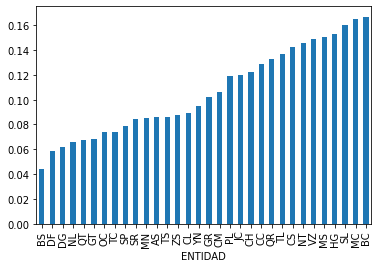

In [27]:
%matplotlib inline
tabla["Letalidad"].plot(kind = "bar")
#plt.bar(tabla.index, tabla["Letalidad"])

In [28]:
tabla = pd.crosstab(data.DIAS_PAS, data.FALLECIDO)
tabla["Letalidad"] = tabla[1]/(tabla[0]+tabla[1])
tabla = tabla.sort_values(by = ["DIAS_PAS"])
tabla

FALLECIDO,0,1,Letalidad
DIAS_PAS,,,
0,157087,15312,0.088817
1,129691,9415,0.067682
2,178027,12643,0.066308
3,199816,15228,0.070813
4,177729,14871,0.077212
5,139181,13835,0.090415
6,93799,11287,0.107407
7,91050,14042,0.133616
8,50572,7236,0.125173


<AxesSubplot:xlabel='DIAS_PAS'>

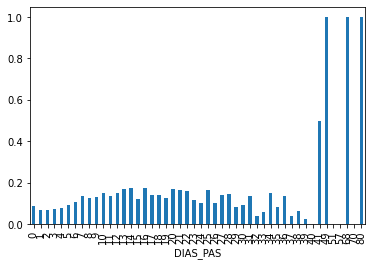

In [29]:
%matplotlib inline
tabla["Letalidad"].plot(kind = "bar")
#plt.bar(tabla.index, tabla["Letalidad"])

### Se eligen solamente las variables que suponemos que tienen un efecto en la mortalidad de los infectados

In [30]:
data["SEXO_V"].unique()

array(['HOMBRE', 'MUJER'], dtype=object)

In [31]:
data["ENTIDAD"].unique()

array(['PL', 'DF', 'JC', 'AS', 'BS', 'YN', 'HG', 'GR', 'QT', 'SL', 'SP',
       'CH', 'QR', 'MN', 'CS', 'NL', 'TC', 'GT', 'BC', 'MC', 'OC', 'MS',
       'TL', 'CC', 'CM', 'VZ', 'TS', 'CL', 'SR', 'ZS', 'NT', 'DG'],
      dtype=object)

In [32]:
data["SECTOR_V"].unique()

array(['SSA', 'ISSSTE', 'PRIVADA', 'IMSS', 'UNIVERSITARIO', 'ESTATAL',
       'SEDENA', 'MUNICIPAL', 'PEMEX', 'IMSS-BIENESTAR', 'SEMAR',
       'CRUZ ROJA', 'DIF'], dtype=object)

Creación de variables dummies

In [33]:
categories = ["SEXO_V","ENTIDAD","SECTOR_V"] 
newCat = []
for category in categories:
    cat_list = category
    cat_dummies = pd.get_dummies(data[category], prefix = cat_list)
    newCat.append(cat_list)
    data = data.join(cat_dummies)

In [34]:
data.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'SEXO_V',
       'SECTOR_V', 'ENTIDAD', 'DIAS_PAS', 'FALLECIDO', 'SEXO_V_HOMBRE',
       'SEXO_V_MUJER', 'ENTIDAD_AS', 'ENTIDAD_BC', 'ENTIDAD_BS', 'ENTIDAD_CC',
       'ENTIDAD_CH', 'ENTIDAD_CL', 'ENTIDAD_CM', 'ENTIDAD_CS', 'ENTIDAD_DF',
       'ENTIDAD_DG', 'ENTIDAD_GR', 'ENTIDAD_GT', 'ENTIDAD_HG', 'ENTIDAD_JC',
       'ENTIDAD_MC', 'ENTIDAD_MN

In [35]:
# Columnas que no se ocuparán (segun el modelo, hay modelo 1 y modelo 2)
# col1, condiciones iniciales del paciente, no ha sido llevado a una unidad médica
col1 = ['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO','NEUMONIA','NACIONALIDAD',
       'HABLA_LENGUA_INDIG', 'INDIGENA','OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN','UCI', 'SECTOR_V','ENTIDAD', 'SECTOR_V_CRUZ ROJA',
       'SECTOR_V_DIF','SECTOR_V_ESTATAL','SECTOR_V_IMSS','SECTOR_V_IMSS-BIENESTAR','SECTOR_V_ISSSTE',
       'SECTOR_V_MUNICIPAL','SECTOR_V_PEMEX','SECTOR_V_PRIVADA','SECTOR_V_SEDENA','SECTOR_V_SEMAR',
       'SECTOR_V_SSA','SECTOR_V_UNIVERSITARIO','DIAS_PAS','SEXO_V'] 
# col2, el paciente ha sido ingresado a una unidad médica
col2 = ['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO','NEUMONIA','NACIONALIDAD',
       'HABLA_LENGUA_INDIG', 'INDIGENA','OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN','UCI','SEXO_V'] 
data_vars = data.columns.tolist()
m1cols = [v for v in data_vars if v not in col1]
m2cols = [v for v in data_vars if v not in col2]


In [36]:
bankData1 = data[m1cols]
bankData1Vars = bankData1.columns.tolist()

In [37]:
Y = bankData1["FALLECIDO"]
xCols = [v for v in bankData1Vars if v != "FALLECIDO"]
X = bankData1[xCols]

In [38]:
len(xCols)

46

### Selección de las variables 

In [39]:
n = 23 # Numero de variables
lr = LogisticRegression()
rfe = RFE(lr,n)
rfe = rfe.fit(X,Y)

In [44]:
varIncluded = list(zip(xCols,rfe.support_,rfe.ranking_))
varIncluded.sort(key = MyF)
print(tabulate(varIncluded))
cols = [v[0] for v in varIncluded if v[1] == True]

--------------  -  --
DIABETES        1   1
EPOC            1   1
ASMA            1   1
INMUSUPR        1   1
HIPERTENSION    1   1
OTRA_COM        1   1
RENAL_CRONICA   1   1
SEXO_V_HOMBRE   1   1
SEXO_V_MUJER    1   1
ENTIDAD_AS      1   1
ENTIDAD_BS      1   1
ENTIDAD_DF      1   1
ENTIDAD_DG      1   1
ENTIDAD_GT      1   1
ENTIDAD_MN      1   1
ENTIDAD_NL      1   1
ENTIDAD_OC      1   1
ENTIDAD_QT      1   1
ENTIDAD_SP      1   1
ENTIDAD_SR      1   1
ENTIDAD_TC      1   1
ENTIDAD_TS      1   1
ENTIDAD_ZS      1   1
ENTIDAD_CL      0   2
ENTIDAD_YN      0   3
ENTIDAD_CM      0   4
ENTIDAD_GR      0   5
ENTIDAD_JC      0   6
ENTIDAD_MC      0   7
OBESIDAD        0   8
ENTIDAD_SL      0   9
ENTIDAD_BC      0  10
ENTIDAD_HG      0  11
ENTIDAD_TL      0  12
ENTIDAD_VZ      0  13
ENTIDAD_CH      0  14
ENTIDAD_QR      0  15
EDAD            0  16
TABAQUISMO      0  17
EMBARAZO        0  18
CARDIOVASCULAR  0  19
ENTIDAD_CS      0  20
ENTIDAD_PL      0  21
ENTIDAD_CC      0  22
ENTIDAD_MS

In [42]:
def MyF (v):
    return v[2]

In [45]:
X = X[cols]

In [46]:
# Separación de los modelos
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

In [47]:
lm1 = linear_model.LogisticRegression()
lm1.fit(X_train,Y_train)

LogisticRegression()

In [48]:
lm1.score(X,Y)

0.9086232757840038

In [49]:
print(tabulate(list(zip(X.columns, np.transpose(lm1.coef_)))))

-------------  ---------
DIABETES        1.00104
EPOC            1.09191
ASMA           -0.423852
INMUSUPR        0.479119
HIPERTENSION    1.0653
OTRA_COM        0.84851
RENAL_CRONICA   0.972782
SEXO_V_HOMBRE  -0.539765
SEXO_V_MUJER   -1.16581
ENTIDAD_AS     -0.551882
ENTIDAD_BS     -1.08538
ENTIDAD_DF     -0.771109
ENTIDAD_DG     -0.706842
ENTIDAD_GT     -0.682365
ENTIDAD_MN     -0.457687
ENTIDAD_NL     -0.723294
ENTIDAD_OC     -0.515915
ENTIDAD_QT     -0.685014
ENTIDAD_SP     -0.606173
ENTIDAD_SR     -0.491491
ENTIDAD_TC     -0.618346
ENTIDAD_TS     -0.512158
ENTIDAD_ZS     -0.444822
-------------  ---------


In [50]:
probs = lm1.predict_proba(X_test)

In [55]:
ps_predicted = []
for p in probs:
    ps_predicted.append(p[1])
ps_predicted[0:10]

[0.04830256858242503,
 0.025218748083045073,
 0.0698284044261077,
 0.09470720911763934,
 0.14057567023735693,
 0.09470720911763934,
 0.025218748083045073,
 0.05021922032229286,
 0.20926897776225753,
 0.3162040791534488]

In [52]:
len(X_test)

440614

In [53]:
X_test.head()

,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,RENAL_CRONICA,SEXO_V_HOMBRE,SEXO_V_MUJER,ENTIDAD_AS,...,ENTIDAD_GT,ENTIDAD_MN,ENTIDAD_NL,ENTIDAD_OC,ENTIDAD_QT,ENTIDAD_SP,ENTIDAD_SR,ENTIDAD_TC,ENTIDAD_TS,ENTIDAD_ZS
828904,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
453062,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
448571,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1253071,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
916427,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [62]:
data.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'SEXO_V',
       'SECTOR_V', 'ENTIDAD', 'DIAS_PAS', 'FALLECIDO', 'SEXO_V_HOMBRE',
       'SEXO_V_MUJER', 'ENTIDAD_AS', 'ENTIDAD_BC', 'ENTIDAD_BS', 'ENTIDAD_CC',
       'ENTIDAD_CH', 'ENTIDAD_CL', 'ENTIDAD_CM', 'ENTIDAD_CS', 'ENTIDAD_DF',
       'ENTIDAD_DG', 'ENTIDAD_GR', 'ENTIDAD_GT', 'ENTIDAD_HG', 'ENTIDAD_JC',
       'ENTIDAD_MC', 'ENTIDAD_MN

In [61]:
X_test.iloc[1]

DIABETES         0
EPOC             0
ASMA             0
INMUSUPR         0
HIPERTENSION     0
OTRA_COM         0
RENAL_CRONICA    0
SEXO_V_HOMBRE    0
SEXO_V_MUJER     1
ENTIDAD_AS       0
ENTIDAD_BS       0
ENTIDAD_DF       1
ENTIDAD_DG       0
ENTIDAD_GT       0
ENTIDAD_MN       0
ENTIDAD_NL       0
ENTIDAD_OC       0
ENTIDAD_QT       0
ENTIDAD_SP       0
ENTIDAD_SR       0
ENTIDAD_TC       0
ENTIDAD_TS       0
ENTIDAD_ZS       0
Name: 453062, dtype: int32

In [66]:
ps_real = []
N = len(X_test)
for i in range(N):
    tmp = data[(data["DIABETES"] == X_test.iloc[i]["DIABETES"])
                & (data["EPOC"] == X_test.iloc[i]["EPOC"])
                & (data["ASMA"] == X_test.iloc[i]["ASMA"])
                & (data["INMUSUPR"] == X_test.iloc[i]["INMUSUPR"])
                & (data["HIPERTENSION"] == X_test.iloc[i]["HIPERTENSION"])
                & (data["OTRA_COM"] == X_test.iloc[i]["OTRA_COM"])
                & (data["RENAL_CRONICA"] == X_test.iloc[i]["RENAL_CRONICA"])
                & (data["SEXO_V_HOMBRE"] == X_test.iloc[i]["SEXO_V_HOMBRE"])
                & (data["SEXO_V_MUJER"] == X_test.iloc[i]["SEXO_V_MUJER"])
                & (data["ENTIDAD_AS"] == X_test.iloc[i]["ENTIDAD_AS"])
                & (data["ENTIDAD_BS"] == X_test.iloc[i]["ENTIDAD_BS"])
                & (data["ENTIDAD_DF"] == X_test.iloc[i]["ENTIDAD_DF"])
                & (data["ENTIDAD_DG"] == X_test.iloc[i]["ENTIDAD_DG"])
                & (data["ENTIDAD_GT"] == X_test.iloc[i]["ENTIDAD_GT"])
                & (data["ENTIDAD_MN"] == X_test.iloc[i]["ENTIDAD_MN"])
                & (data["ENTIDAD_NL"] == X_test.iloc[i]["ENTIDAD_NL"])
                & (data["ENTIDAD_OC"] == X_test.iloc[i]["ENTIDAD_OC"])
                & (data["ENTIDAD_QT"] == X_test.iloc[i]["ENTIDAD_QT"])
                & (data["ENTIDAD_SP"] == X_test.iloc[i]["ENTIDAD_SP"])
                & (data["ENTIDAD_SR"] == X_test.iloc[i]["ENTIDAD_SR"])
                & (data["ENTIDAD_TC"] == X_test.iloc[i]["ENTIDAD_TC"])
                & (data["ENTIDAD_TS"] == X_test.iloc[i]["ENTIDAD_TS"])
                & (data["ENTIDAD_ZS"] == X_test.iloc[i]["ENTIDAD_ZS"])]
    total = len(tmp)
    fallecidos = len(tmp[tmp["FALLECIDO"] == 1])
    ps_real.append(fallecidos/total)

KeyboardInterrupt: 